# Tennessee Fuel Quality Analysis

* **Date Published**: 2019/07/31
* **Collaborators**: [Kate Hayes](https://github.com/99KHayes) & [Misha Berrien](https://github.com/mishaberrien)
* **Data Source**: State of Tennessee Department of Agriculture

## Introduction   

In this project, we are interested in understanding if we can predict when a fuel compliance test will fail. 

The state of Tennessee's Department of Agriculture (TDA) maintaines a fuel quality inspection program. Each year, the state inspects all places where fuel is sold/ distributed including gas stations, terminals and airports. The results of these routine tests as well as follow up tests for complaints are maintained by the Tennessee Department of Agriculture. 

Although around 97% of the tests pass these compliance tests, each year around 3% of the tests fail. A failing test could mean that consumers are exposed to fuel that could do harm to their property or themselves. 

## Dataset

Tennessee has a Sunshine law (public records law) that allows anyone to request any state record through the right legal channels. The data set was acquired in this manor. We sent an official Tennessee records request for the fuel quality data for the last 5 years. It came in the form of routine inspections and complaints one set for each years, so 10 Excel files in total.

* Source: State of Tennessee Department of Agriculture
* Time Period: Mid 2014 to early 2019
* Number of Fuel Products: 11
* Number of Test Types: 72

## Key Metrics

***The following key metrics were descriptions given to us by the TDA Fuel Quality Manager. The main thing that we were inspecting in this project was the prediction of pass/fail rates and volatility properties with the seasons.*** 

Volatility is an important property of gasoline because it must be able to vaporize before combusting in an engine. Three characteristics are used to measure the volatility of gasoline and evaluate suitability: vapor pressure, vapor-liquid ratio, and the distillation temperature at which 50% of the fuel is evaporated.


* Vapor pressure is a measure of the amount of vapor that is produced by a gasoline sample at 37.8°C (100°F). Vapor pressure most affects an engine’s ease of starting. The vapor pressure specification is a maximum allowable limit reported in kilopascals. The pressure must be high enough to promote easy starting but not too high to contribute to excessive emissions or vapor lock -  the presence of too much vapor that leads to loss of engine power or rough operation.


* Vapor-liquid ratio is the ratio of the volume of vapor to the volume of liquid at atmospheric pressure. The vapor-liquid ratio specification is a minimum allowable limit reported in degrees Celsius. The reported value is the temperature at which the vapor-liquid ratio is equal to 20 (20:1 vol/vol), the approximate temperature at which engine problems may occur. Vapor-liquid ratio is used to evaluate a gasoline sample’s tolerance to changes in temperature. A noncompliant test result (too low) may lead to vapor lock or hot fuel handling problems, as evidenced by loss of power while accelerating or idling.


* Distillation measures the temperature range across which a sample is heated to fully evaporate. The temperature at which 50% of a sample is evaporated (T50) relates to the driveability (smoothness and ease of driving) and idling characteristics for the fuel. T50 most similarly relates to how a fuel performs under continuous activity (not starting or warming up). T50 has minimum and maximum allowable limits reported in degrees Celsius.

## Questions

For this project, we are interested in two distinct questions: 

1. Is there seasonality associated with fuel compliance tests failures in the state of Tennessee? 
1. Can we use data collected by fuel inspectors to better predict gas station fuel test failures in the state of Tennessee?

## Logistic Regression Analysis

The original dataset contains information tests for a number of different fuels (jet fuel, diesel, gasoline, etc.). For this project, we are only interested in making predictions about consumer facing gas-stations, so we have restricted our dataset to gasoline products. Below we load and clean our dataset as well as build and evaluate our model. 

### Load and Process Datasets

_**NOTE:** The functions for cleaning and processing the dataset can be found in the src/d03 processing folder_

The four functions called below clean, concatenate and prepare the dataset for model building. Our dataset was originally spread across 5 years. The below functions concatenated all years, imputed missing values and dropped null values and unnecessary columns. Below we also read in the dataset ASTM (this set contains seasonal information for Tennessee gasoline requirements) and merge it with our original dataset. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats as stat
import seaborn as sns
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm
import sys

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

# helper functions
from d01_data.intermediate_cleaning import concatenate_and_save_intermediate_files, clean_dataset_intermediate_1, clean_dataset_intermediate_2
from d03_processing.feature_engineering import merge_gasoline_asm_datasets
from d04_modelling.modelling import get_model_pvalue
from d03_processing.Time_series_cleaning import date_results_df_creator
from d03_processing.Time_series_cleaning import volatilty_ASTM_df_creator
from d03_processing.Time_series_cleaning import stationarity_check
from d03_processing.Time_series_cleaning import seasonal_decomp_graphs

# Load the "autoreload" extension
%load_ext autoreload

# reload modules so that as you change code in src, it gets loaded
%autoreload

%matplotlib inline

In [2]:
# gasoline_proc = pd.read_csv('../../data/03_processed/gasoline_processed.csv')
astm = pd.read_csv('../../data/01_raw/ASTM_fuel.csv')
astm.columns = ['Date', 'TN_retailers_seasons', 'TN_distributor_seasons',
       'vapor_liquid_minC_retail', 'distillation_50_minC _retail',
       'distillation_50_maxC_retail', 'vapor_pressure_maxC_retail',
       'vapor_liquid_minC_dist', 'distillation_50_minC_dist',
       'distillation_50_maxC_dist', 'vapor_pressure_maxC_dist']

In [3]:
concatenate_and_save_intermediate_files('fy_*_routine', 'routine_full')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (0,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
routine_full = pd.read_csv('../../data/02_intermediate/routine_full.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
routine_clean = clean_dataset_intermediate_1(routine_full)

In [6]:
gasoline_clean = clean_dataset_intermediate_2(routine_clean)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
gasoline = merge_gasoline_asm_datasets(gasoline_clean, astm)

### Visualize Final Dataset

Let's take a look at our final dataset before we fit our first model. 

In [8]:
gasoline.head(3)

,Sample,prod,datesampled,grade,supplier,facilityname,siteaddress,units_dist_50,units_vap_pressure,units_vap_liq_pressure,...,TN_retailers_seasons,TN_distributor_seasons,vapor_liquid_minC_retail,distillation_50_minC _retail,distillation_50_maxC_retail,vapor_pressure_maxC_retail,vapor_liquid_minC_dist,distillation_50_minC_dist,distillation_50_maxC_dist,vapor_pressure_maxC_dist
0,61916134,Gasoline,2015-11-23,Mid Grade Unleaded,Marathon Petroleum Lp,Circle K #2723609,"198 Haywood Ln \r\nnashville, Tn 37211",Deg. C,kPa,Deg. C,...,C-3/D-4,C-3/D-4,42.0,77.0,116.0,93.0,42.0,77.0,116.0,93.0
1,61916136,Gasoline,2015-11-24,Mid Grade Unleaded,Tri-star Energy,Twice Daily #8085,"648 Thompson Ln \r\nnashville, Tn 37204",Deg. C,kPa,Deg. C,...,C-3/D-4,C-3/D-4,42.0,77.0,116.0,93.0,42.0,77.0,116.0,93.0
2,61916138,Gasoline,2015-11-24,Regular Unleaded,"Mapco Express, Inc.",Mapco Express #3195,"4677 Trousdale Dr Nashville, Tn 37204",Deg. C,kPa,Deg. C,...,C-3/D-4,C-3/D-4,42.0,77.0,116.0,93.0,42.0,77.0,116.0,93.0


In the final dataset, we have 38 columns and 12,974 rows. 

In [9]:
gasoline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12983 entries, 0 to 12982
Data columns (total 38 columns):
Sample                          12983 non-null object
prod                            12983 non-null object
datesampled                     12983 non-null datetime64[ns]
grade                           12983 non-null object
supplier                        12983 non-null object
facilityname                    12983 non-null object
siteaddress                     12983 non-null object
units_dist_50                   12983 non-null object
units_vap_pressure              12983 non-null object
units_vap_liq_pressure          12983 non-null object
method_dist_50                  12983 non-null object
method_vap_pressure             12983 non-null object
method_vap_liq_pressure         12983 non-null object
result_dist_50                  12983 non-null object
result_vap_pressure             12983 non-null object
result_vap_liq_pressure         12983 non-null object
minresults_dist_50 

We still have have a few columns with Nan values (these are from our merged dataset in the data cleaning). Since it's only 

In [10]:
gasoline.dropna(inplace=True)

In [11]:
gasoline.corr()

,datesampled_month,datesampled_day,vapor_liquid_minC_retail,distillation_50_minC _retail,distillation_50_maxC_retail,vapor_pressure_maxC_retail,vapor_liquid_minC_dist,distillation_50_minC_dist,distillation_50_maxC_dist,vapor_pressure_maxC_dist
datesampled_month,1.000000,-0.040802,0.145394,NaN,0.084380,-0.206351,0.145394,NaN,0.084380,-0.131068
datesampled_day,-0.040802,1.000000,-0.015677,NaN,-0.000156,0.030501,-0.015677,NaN,-0.000156,0.043354
vapor_liquid_minC_retail,0.145394,-0.015677,1.000000,NaN,0.730640,-0.937519,1.000000,NaN,0.730640,-0.937577
distillation_50_minC _retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distillation_50_maxC_retail,0.084380,-0.000156,0.730640,NaN,1.000000,-0.728607,0.730640,NaN,1.000000,-0.761139
vapor_pressure_maxC_retail,-0.206351,0.030501,-0.937519,NaN,-0.728607,1.000000,-0.937519,NaN,-0.728607,0.946643
vapor_liquid_minC_dist,0.145394,-0.015677,1.000000,NaN,0.730640,-0.937519,1.000000,NaN,0.730640,-0.937577
distillation_50_minC_dist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distillation_50_maxC_dist,0.084380,-0.000156,0.730640,NaN,1.000000,-0.728607,0.730640,NaN,1.000000,-0.761139
vapor_pressure_maxC_dist,-0.131068,0.043354,-0.937577,NaN,-0.761139,0.946643,-0.937577,NaN,-0.761139,1.000000


### Build & Choose Model

#### Model 1: Vapor Liquid-Ratio Test Outcome ~ Grade

In [12]:
# construct features 
x_feats = ['grade']
X = pd.get_dummies(gasoline[x_feats], dtype=float)
X = sm.tools.add_constant(X)
# convert target using get_dummies
y = gasoline.compliance_vap_liq_pressure.map({'Y': 0, 'N': 1})

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [14]:
print('Original Count:', '\n')
print("Label Count '1': {}".format(sum(y_train==1)))
print("Label Count '0': {} \n".format(sum(y_train==0)))

Original Count: 

Label Count '1': 26
Label Count '0': 9055 



Our dataset is heavily imbalanced with a 26 to 9,055 ratio of 1s to 0s in our training set. In order to find a reliable result, we need to balance these numbers with oversampling. 

##### Oversampling

Let's use SMOTE to create synthetic data points. 

In [15]:
smote = SMOTE()

# simple resampling from your previously split data
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train.ravel())

In [16]:
print('Updated w. Smote:', '\n')
print("Label Count '1': {}".format(sum(y_train_resampled==1)))
print("Label Count '0': {} \n".format(sum(y_train_resampled==0)))

Updated w. Smote: 

Label Count '1': 9055
Label Count '0': 9055 



We now have a balanced dataset to build our models with. Let's build our first model. 

In [17]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log1 = logreg.fit(X_train_resampled, y_train_resampled)
model_log1

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

##### Testing Model 1

Let's make predictions with the test and train dataset for our first model and check the accuracy score. 

In [18]:
y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

In [19]:
print('Training Accuracy: ', accuracy_score(y_train, y_pred_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_pred_test))

Training Accuracy:  0.520537385750468
Testing Accuracy:  0.5278705368610326


This model gives us an accuracy only slightly better than chance. Let's build a second model and see if we can raise the accuracy score. 

#### Model 2: Vapor Liquid-Ratio Test Outcome ~ Tennessee Retailers Season & Grade

We will repeat the process laid out above for our second model

In [20]:
# construct features 
x_feats = ['TN_retailers_seasons', 'grade']
X = pd.get_dummies(gasoline[x_feats], dtype=float)
X = sm.tools.add_constant(X)
# convert target using get_dummies
y = gasoline.compliance_vap_liq_pressure.map({'Y': 0, 'N': 1})

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=0, stratify=y)

In [22]:
smote = SMOTE()

# simple resampling from your previously split data
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train.ravel())

In [23]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log2 = logreg.fit(X_train_resampled, y_train_resampled)
model_log2

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

In [25]:
print('Training Accuracy: ', accuracy_score(y_train, y_pred_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_pred_test))

Training Accuracy:  0.7098337187534413
Testing Accuracy:  0.6943231441048034


Our accuracy score is higher for our second model. Let's take a look at other scores for our second model to see how well it's performing. 

### Further Testing of Chosen Model

#### Precision, Recall and F1-Score

Let's score our model. The F1-Score for the training and test dataset are relatively close to one another (0.79 to 0.88 respectively). Our model test scores seem very high. Let's take a look at a ROC curve and confusion matrix for our chosen model to get a better understanding of what's going on. 

In [26]:
print('Training Precision: ', precision_score(y_train, y_pred_train))
print('Testing Precision: ', precision_score(y_test, y_pred_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_pred_train))
print('Testing Recall: ', recall_score(y_test, y_pred_test))
print('\n\n')

print('Training F1-Score: ',f1_score(y_train, y_pred_train))
print('Testing F1-Score: ',f1_score(y_test, y_pred_test))

Training Precision:  0.007921539041870993
Testing Precision:  0.008340283569641367



Training Recall:  0.8076923076923077
Testing Recall:  0.9090909090909091



Training F1-Score:  0.015689204333208816
Testing F1-Score:  0.01652892561983471


#### ROC Curve & AUC

In [27]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

AUC: 0.8535899957847408


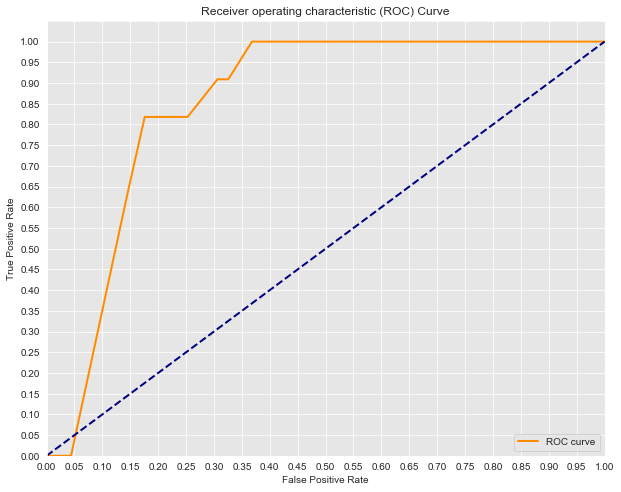

In [28]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("../../results/Images/roc.jpg")

Our ROC curve is slightly above the 45 degree line. This means that it's only slightly better than random chance. Let's take a closer look at the predictions our model makes.

In [29]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,2693,1189
actual 1,1,10


In [30]:
tp = conf_matrix.loc['actual 0', 'predicted 0']
tn = conf_matrix.loc['actual 1', 'predicted 1']
fp = conf_matrix.loc['actual 0', 'predicted 1']
fn = conf_matrix.loc['actual 1', 'predicted 0']

Our confusion matrix looks a little odd. Let's calculate the false positive rate. The equation is found below: 

$$FPR = \frac{FP}{FP + TN}$$

In [31]:
print("False Positive Rate: {}%".format((fp/(fp+tn))*100))

False Positive Rate: 99.16597164303586%


Our model's False positive rate is incredibly high. At this point, our model is classifying a large number of data points as positives when they are not (our dataset contains no false negatives which is telling). Let's take a look at the model's true positive rate (the calculation for true positive rate is found below). 

$$𝑇𝑃𝑅 = \frac{𝑇𝑃}{𝑇𝑃 + 𝐹𝑁}$$

In [32]:
print("True Positive Rate: {}%".format((tp/(tp+fn))*100))

True Positive Rate: 99.96288047512992%


Our model has a true positive rate of 100%. This means that our model accurately predicting every gas station that will fail a test, but it also predicts a high number of false positives. 

### Summary & Caveats

#### Logistic Regression Analysis

Out of the two models built for predicting failure of the vapor liquid pressure test, our second model had a higher accuracy score. The ROC curve for our model was promising, but the confusion matrix revealed that our model has a high false positive rate (over 99%). This means that although we correctly identified 10 out of 11 tests as failing, we also falsely predicted almost 1,200 other tests would fail. 

For this particular problem, high sensitivity for our model is desirable, but a sensitivity near 1 is going to produce a large number of false positives which could be costly for this particular problem. In order to improve the model we could tune the threshold, but because the precision and F1 score were so low, we it would be more desirable to use additional predictors in an updated model. 

## Conclusion & Next Steps

### Logistic Regression 

#### Conclusion 

Although our model correctly identified 10 out of 11 of our test failures, this model had a false positive rate that was too high for our usage purposes. Additional models need to be built and tested in order to improve the F1 and precision scores. 

#### Next Steps

* Do tests that pass but barely pass lead to more complaints?
* Do certain regions of Tennessee have more failures in certain seasons
* Do certain brands of gas stations or distributors deliver more failures or have more complaints against them